# **Convolutional Autoencoder with Deconvolutions and Continuous Jaccard Distance**

## **Libraries**

In [1]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import numpy as np
import torch
import time

In [2]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [3]:
def continuous_jaccard(x, y):
    c = torch.cat((x.view(-1).unsqueeze(1), y.view(-1).unsqueeze(1)), dim=1)
    numerator = torch.sum(torch.min(c, dim=1)[0])
    denominator = torch.sum(torch.max(c, dim=1)[0])
    return 1. - numerator/denominator

x = torch.tensor([7, 2, 3, 4, 5, 6]).float()
y = torch.tensor([1, 8, 9, 10, 11, 4]).float()

continuous_jaccard(x, y)

tensor(0.6275)

## **Settings**

In [4]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 456
learning_rate = 0.005
num_epochs = 10
batch_size = 128

## **MNIST dataset**

In [5]:
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())

In [6]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

In [7]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## **Model**

In [8]:
class ConvolutionalAutoencoder(torch.nn.Module):
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) 
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0)                                       
        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=8,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)                 
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0)
        self.deconv_1 = torch.nn.ConvTranspose2d(in_channels=8,
                                                 out_channels=4,
                                                 kernel_size=(3, 3),
                                                 stride=(2, 2),
                                                 padding=0)
        self.deconv_2 = torch.nn.ConvTranspose2d(in_channels=4,
                                                 out_channels=1,
                                                 kernel_size=(3, 3),
                                                 stride=(2, 2),
                                                 padding=0)
    def forward(self, x):
        x = self.conv_1(x)
        x = F.leaky_relu(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = F.leaky_relu(x)
        x = self.pool_2(x)
        x = self.deconv_1(x)
        x = F.leaky_relu(x)
        x = self.deconv_2(x)
        x = F.leaky_relu(x)
        logits = x[:, :, 2:30, 2:30]
        probas = torch.sigmoid(logits)
        return logits, probas

In [9]:
torch.manual_seed(random_seed)
model = ConvolutionalAutoencoder()
model = model.to(device)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

## **Training phase**

In [11]:
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(device)
        logits, decoded = model(features)
        cost = continuous_jaccard(features, decoded)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/468 | Cost: 0.8569
Epoch: 001/010 | Batch 050/468 | Cost: 0.7992
Epoch: 001/010 | Batch 100/468 | Cost: 0.7689
Epoch: 001/010 | Batch 150/468 | Cost: 0.7073
Epoch: 001/010 | Batch 200/468 | Cost: 0.3603
Epoch: 001/010 | Batch 250/468 | Cost: 0.2804
Epoch: 001/010 | Batch 300/468 | Cost: 0.2691
Epoch: 001/010 | Batch 350/468 | Cost: 0.2787
Epoch: 001/010 | Batch 400/468 | Cost: 0.2603
Epoch: 001/010 | Batch 450/468 | Cost: 0.2604
Time elapsed: 0.55 min
Epoch: 002/010 | Batch 000/468 | Cost: 0.2480
Epoch: 002/010 | Batch 050/468 | Cost: 0.2478
Epoch: 002/010 | Batch 100/468 | Cost: 0.2592
Epoch: 002/010 | Batch 150/468 | Cost: 0.2509
Epoch: 002/010 | Batch 200/468 | Cost: 0.2478
Epoch: 002/010 | Batch 250/468 | Cost: 0.2442
Epoch: 002/010 | Batch 300/468 | Cost: 0.2348
Epoch: 002/010 | Batch 350/468 | Cost: 0.2407
Epoch: 002/010 | Batch 400/468 | Cost: 0.2280
Epoch: 002/010 | Batch 450/468 | Cost: 0.2378
Time elapsed: 1.10 min
Epoch: 003/010 | Batch 000/468 | C

## **Evaluation**

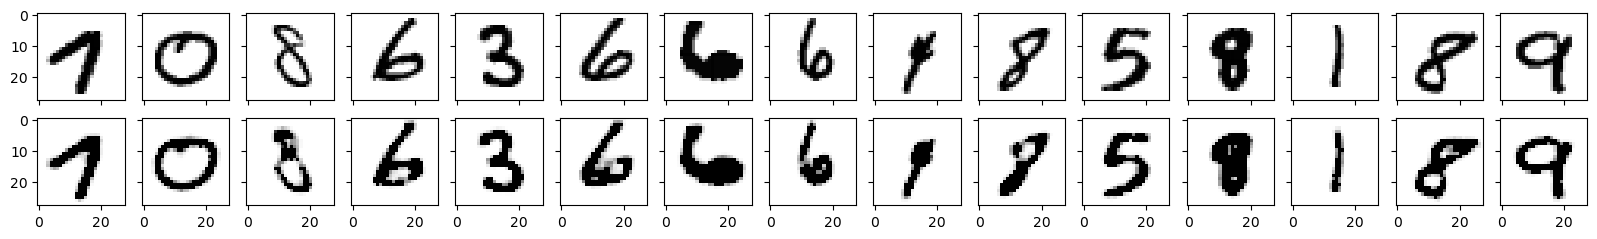

In [12]:
n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')